# Blood Pressure Estimation from PPG with Barlow Twins

In [1]:
import numpy as np
from scipy.signal import butter, sosfiltfilt, find_peaks, savgol_filter, welch
import matplotlib.pyplot as plt
from data_utilities.signal_processing import plot_signal, create_windows, interpolate_nan_pchip
from data_utilities.augmentations import RandomAugmentor

2025-01-02 18:13:29.714439: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 18:13:29.765191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-02 18:13:30.552938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


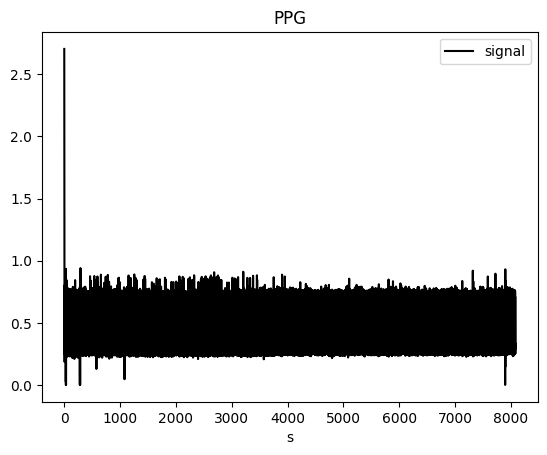

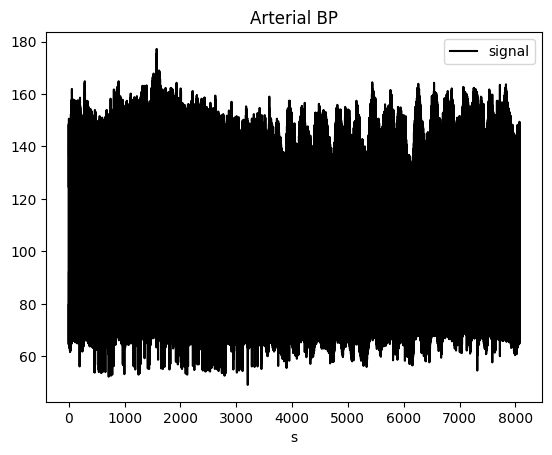

<Figure size 640x480 with 0 Axes>

In [2]:
ppg = np.load('dataset/mimic_iii/p00/p001158/3307993_0014/ppg.npy')
abp = np.load('dataset/mimic_iii/p00/p001158/3307993_0014/abp.npy')
fs = 125

plot_signal(ppg, fs, title='PPG')
plot_signal(abp, fs, title='Arterial BP')

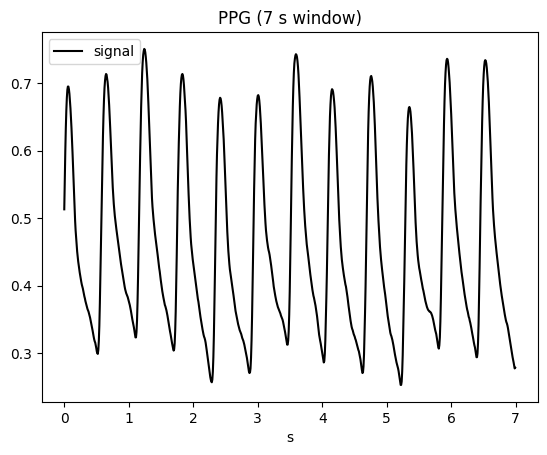

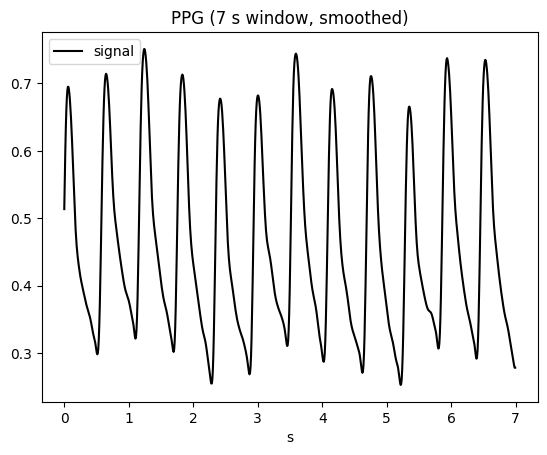

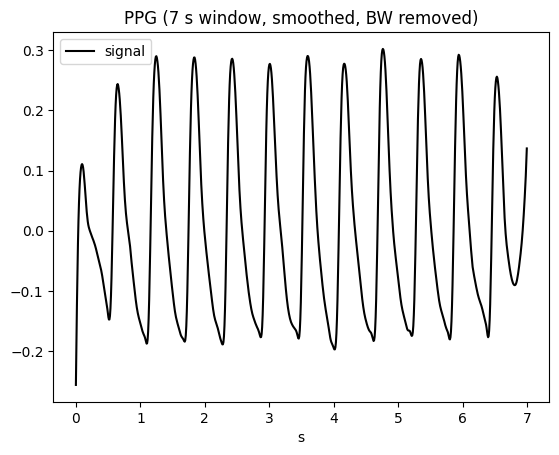

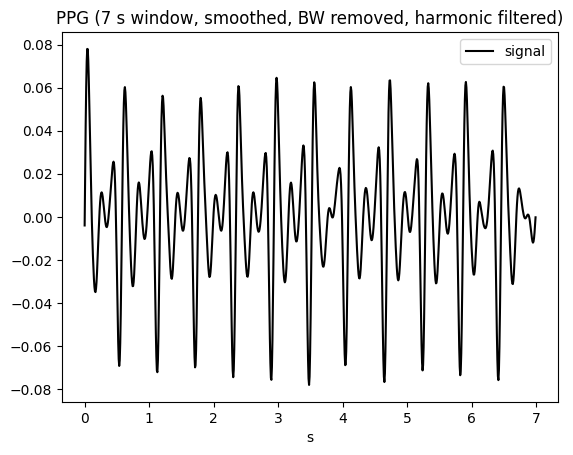

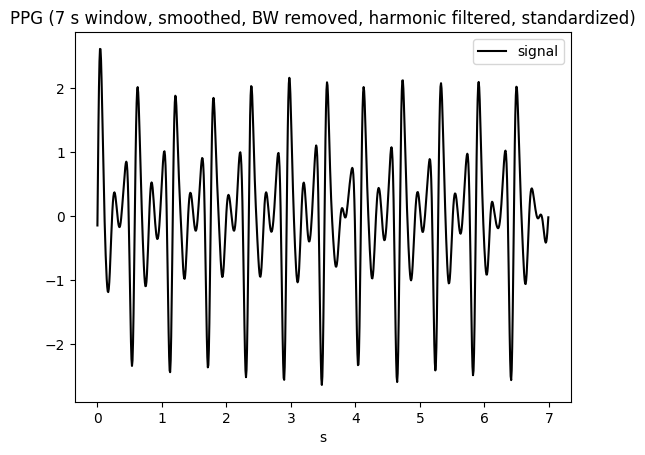

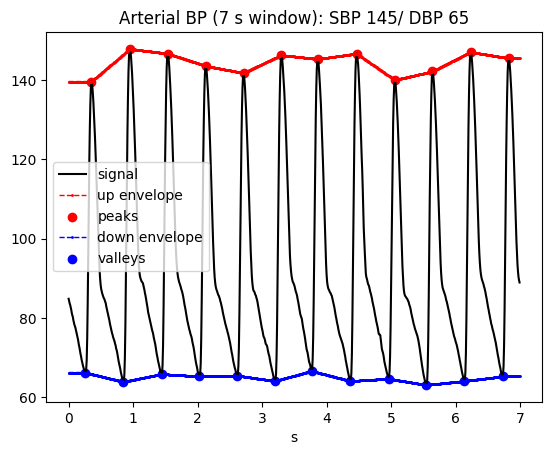

<Figure size 640x480 with 0 Axes>

In [3]:
win_len =  7
overlap = 0.5
filter_order = 2
n_samples = abp.shape[0]
SBP_min, SBP_max = 60, 220 
DBP_min, DBP_max = 30, 140
win_start, win_stop = create_windows(win_len, fs, n_samples, overlap)
n_win = len(win_start)

abp_peaks = find_peaks(abp)[0]
abp_valleys = find_peaks(-abp)[0]

for i in range(0, n_win):
        
    idx_start = win_start[i]
    idx_stop = win_stop[i]

    ppg_win = ppg[idx_start:idx_stop+1]
        
    # Sanity check if enough peak values are present and if the number of SBP peaks matches the number of DBP peaks
    ABP_sys_idx_win = abp_peaks[np.logical_and(abp_peaks >= idx_start, abp_peaks < idx_stop)].astype(int)
    ABP_dia_idx_win = abp_valleys[np.logical_and(abp_valleys >= idx_start, abp_valleys < idx_stop)].astype(int)

    if ABP_sys_idx_win.shape[-1] < (win_len/60)*40 or ABP_sys_idx_win.shape[-1] > (win_len/60)*120:
        continue

    if ABP_dia_idx_win.shape[-1] < (win_len/60)*40 or ABP_dia_idx_win.shape[-1] > (win_len/60)*120:
        continue

    if len(ABP_sys_idx_win) != len(ABP_dia_idx_win):
        if ABP_sys_idx_win[0] > ABP_dia_idx_win[0]:
            ABP_dia_idx_win = np.delete(ABP_dia_idx_win,0)
        if ABP_sys_idx_win[-1] > ABP_dia_idx_win[-1]:
            ABP_sys_idx_win = np.delete(ABP_sys_idx_win,-1)

    ABP_sys_win = abp[ABP_sys_idx_win]
    ABP_dia_win = abp[ABP_dia_idx_win]

    # check if any of the SBP or DBP values exceed reasonable vlaues
    if np.any(np.logical_or(ABP_sys_win < SBP_min, ABP_sys_win > SBP_max)):
        continue

    if np.any(np.logical_or(ABP_dia_win < DBP_min, ABP_dia_win > DBP_max)):
        continue

    # check for NaN in the detected SBP and DBP peaks
    if np.any(np.isnan(ABP_sys_win)) or np.any(np.isnan(ABP_dia_win)):
        continue

    # First replace NaNs that may affect the computation
    ppg_win = interpolate_nan_pchip(ppg_win)

    plot_signal(ppg_win, fs, title='PPG (7 s window)')

    # S-G filter to smooth the signal
    ppg_win = savgol_filter(ppg_win, window_length=25, polyorder=7)
    
    plot_signal(ppg_win, fs, title='PPG (7 s window, smoothed)')

    # S-G filter to remove baseline wander
    filtered_ppg_win = savgol_filter(ppg_win, window_length=211, polyorder=5)
    ppg_win = ppg_win - filtered_ppg_win

    plot_signal(ppg_win, fs, title='PPG (7 s window, smoothed, BW removed)')
    
    # Harmonic filtering from CardioID
    fh, Pxx_den = welch(ppg_win, fs=fs, window='hann', axis=0)
    
    # Find the peak frequency (+1 to avoid having a zero as first frequency)
    first_harmonic = fh[np.argmax(Pxx_den) + 1]

    # Adaptive Butterworth filtering
    lowcut = 2 * first_harmonic
    highcut = 5.5 * first_harmonic
    
    sos_ppg = butter(filter_order,
                    [lowcut, highcut],
                    btype='bp',
                    analog=False,
                    output='sos',
                    fs=fs)
    ppg_win = sosfiltfilt(sos_ppg, ppg_win)

    plot_signal(ppg_win, fs, title='PPG (7 s window, smoothed, BW removed, harmonic filtered)')

    # Standardize PPG
    ppg_win = ppg_win - np.mean(ppg_win)
    ppg_win = ppg_win / np.std(ppg_win)

    processed_input_ppg  = ppg_win

    plot_signal(ppg_win, fs, title='PPG (7 s window, smoothed, BW removed, harmonic filtered, standardized)')

    # calculate the BP ground truth as the median of all SBP and DBP values in the present window
    BP_sys = np.median(ABP_sys_win).astype(int)
    BP_dia = np.median(ABP_dia_win).astype(int)

    label = [BP_sys, BP_dia]
    
    abp_win = abp[idx_start:idx_stop+1]
    plot_signal(abp_win, fs, peaks=ABP_sys_idx_win - idx_start, valleys=ABP_dia_idx_win - idx_start, title=f'Arterial BP (7 s window): SBP {BP_sys}/ DBP {BP_dia}')
    break
    

In [9]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer


class Augmentation(Layer):
    """Base augmentation class.
    https://github.com/uchidalab/time_series_augmentation/blob/master/utils/augmentation.py#L8

    Base augmentation class. Contains the random_execute method.

    Methods:
        random_execute: method that returns true or false based 
          on a probability. Used to determine whether an augmentation 
          will be run.
    """

    def __init__(self, seed):
        super().__init__()
        self.seed = seed

    def random_execute(self, prob: float) -> bool:
        """random_execute function.

        Arguments:
            prob: a float value from 0-1 that determines the 
              probability.

        Returns:
            returns true or false based on the probability.
        """

        return tf.random.uniform([], minval=0, maxval=1, seed=self.seed) < prob


class Jitter(Augmentation):
    def __init__(self, seed, sigma=0.05):
        super().__init__(seed)
        self.seed = seed
        self.sigma = sigma

    def call(self, inputs, prob=1.0):
        if self.random_execute(prob=prob):
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.sigma, seed=self.seed)
            return inputs + noise
        else:
            return inputs


class Scaling(Augmentation):
    def __init__(self, seed, sigma=0.1):
        super().__init__(seed)
        self.seed = seed
        self.sigma = sigma

    def call(self, inputs, prob=1.0):
        if self.random_execute(prob=prob):
            factor = tf.random.normal(shape=tf.shape(inputs), mean=1.0, stddev=self.sigma, seed=self.seed)
            return inputs * factor
        else:
            return inputs


class Flip(Augmentation):
    def __init__(self, seed):
        super(Flip, self).__init__(seed)
        self.seed = seed

    def call(self, inputs, prob=1.0):
        if self.random_execute(prob=prob):
            # Randomly flip each feature
            flips = tf.random.uniform(shape=tf.shape(inputs), minval=-1.0, maxval=1.0, seed=self.seed)
            flips = tf.where(flips > 0.0, tf.ones_like(flips), -tf.ones_like(flips))

            # Randomly permute feature order (N.B. input is (n_inputs,))
            rotate_axis = tf.random.shuffle(tf.range(tf.shape(inputs)[0]), seed=self.seed)
            rotated_inputs = tf.gather(inputs, rotate_axis, axis=0)

            # Apply flips
            return flips * rotated_inputs
        else:
            return inputs
    

class RandomAugmentor(Model):
    """RandomAugmentor class.

    RandomAugmentor class. Chains all the augmentations into 
    one pipeline.

    Attributes:
        time_shift: Instance variable representing the TimeShift layer.
        scaling: Instance variable representing the Scaling layer.
        noise_injection: Instance variable representing the NoiseInjection layer.
        time_warp: Instance variable representing the TimeWarp layer.

    Methods:
        call: chains layers in pipeline together
    """

    def __init__(self, seed):
        super().__init__()
        self.jitter = Jitter(seed)
        self.scaling = Scaling(seed)
        self.flip = Flip(seed)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        x_jit = self.jitter(x)
        x_scal = self.scaling(x)
        x_flip = self.flip(x)
        return x_jit, x_scal, x_flip

In [5]:
processed_input_ppg.shape

(875,)

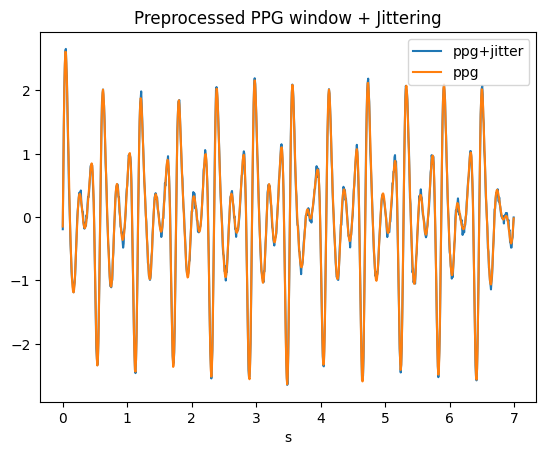

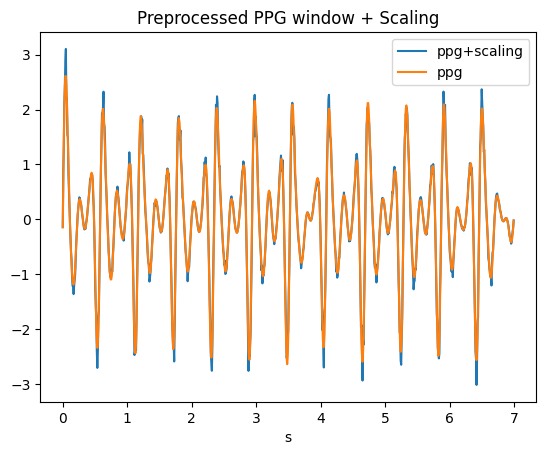

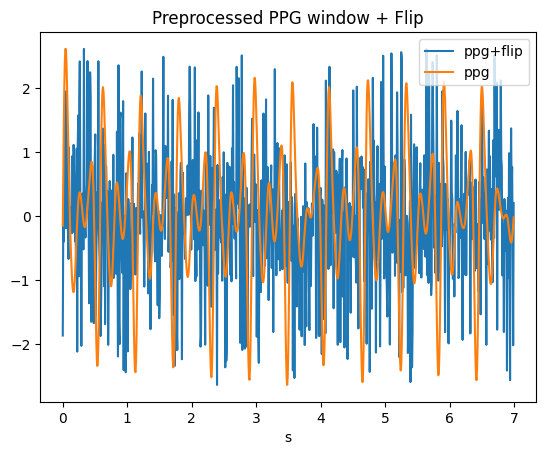

<Figure size 640x480 with 0 Axes>

In [10]:
seed = 42
in_shape = processed_input_ppg.shape
augmentor = RandomAugmentor(seed)
ppg_jitter, ppg_scaling, ppg_flip = augmentor(processed_input_ppg)

title = 'Preprocessed PPG window + Jittering'
t = np.arange(0, (875 / fs), 1.0 / fs)
plt.title(f'{title}')
plt.xlabel('s')
plt.plot(t, tf.squeeze(ppg_jitter), label='ppg+jitter')
plt.plot(t, tf.squeeze(processed_input_ppg), label='ppg')
plt.legend()
plt.show()
plt.clf()

title = 'Preprocessed PPG window + Scaling'
t = np.arange(0, (875 / fs), 1.0 / fs)
plt.title(f'{title}')
plt.xlabel('s')
plt.plot(t, tf.squeeze(ppg_scaling), label='ppg+scaling')
plt.plot(t, tf.squeeze(processed_input_ppg), label='ppg')
plt.legend()
plt.show()
plt.clf()

title = 'Preprocessed PPG window + Flip'
t = np.arange(0, (875 / fs), 1.0 / fs)
plt.title(f'{title}')
plt.xlabel('s')
plt.plot(t, tf.squeeze(ppg_flip), label='ppg+flip')
plt.plot(t, tf.squeeze(processed_input_ppg), label='ppg')
plt.legend()
plt.show()
plt.clf()